## Autorzy

1. Konrad Filek 
2. Wojciech Kozioł

## Opis problemu

Nasza praca będzie realizować próbę sprawdzenia, 
czy dana płatność jest próbą oszustwa, czy tez nie, na podstawie bazy danych CSV
pobranej ze strony kaggle.com

Link do zbioru danych: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Zbiór danych wybrany przez nas, został stworzony na bazie transakcji wykonanych kartami kredytowymi we wrześniu 2013 w europie na przestrzeni dwóch dni, gdzie z pośród 284 807 transakcji, zakwalifikowano 492 oszustwa.

## Czym jest "analiza składowych głowny (PCA)"

Źródło: https://www.statystyka.az.pl/analiza-skladowych-glownych-pca.php

"Analiza składowych głównych (PCA) służy m.in. do redukcji liczby zmiennych opisujących zjawiska, czy do odkrycia prawidłowości między zmiennymi. Polega ona na wyznaczeniu składowych będących kombinacją liniową badanych zmiennych. Dokładna analiza składowych głównych umożliwia wskazanie tych zmiennych początkowych, które mają duży wpływ na wygląd poszczególnych składowych głównych czyli tych, które tworzą grupę jednorodną. Składowa główna (u której wariancja jest zmaksymalizowana) jest wówczas reprezentantem tej grupy."

Kolejne składowe:

- są wzajemnie nieskorelowane,
- są definiowane tak, aby zmaksymalizować zmienność, która nie została wyjaśniona przez poprzednią składową,

Liczba składowych jest mniejsza lub równa liczbie zmiennych początkowych. 
Wariancja składowej głównej `Zi` jest równa `i-tej` co do wielkości wartości własnej macierzy `𝔸`.
Całkowita wariancja układu jest równa `λ1+λ2+…+λp`(gdzie `λi` dla `i∈{1,2,…,p}`są wszystkimi wartościami własnymi macierzy `𝔸`). 
Dzięki temu możemy zdefiniować część wariancji dla `i-tej` składowej według wzoru:

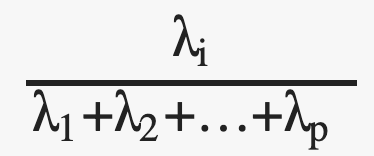

## Opis danych ze zbioru danych

- `time` czas dokonania transakcji
- `V1 - V28` cechy transakcji uzyskane na podstawie transformacji PCA
- `amount` kwota transakcji
- `class` definiuje transakcje czy jest oszustwem (wartość `1`), czy tez nie (wartość `0`)

## Realizacja programu
### Import bibliotek

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

### Ladowanie danych

In [2]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time', axis=1)

za pomocą `df.head()` sprawdzamy pięc pierwszych wierszy danych które załadowaliśmy

In [3]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print("Dane: ilość wierszy:",df.shape[0]," ilość kolumn:", df.shape[1])

Dane: ilość wierszy: 284807  ilość kolumn: 30


<AxesSubplot:>

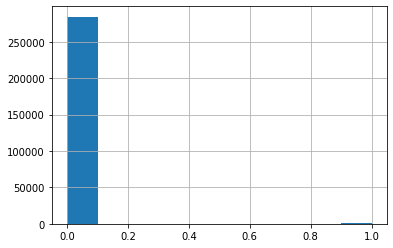

In [6]:
df['Class'].hist()

In [7]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Sprawdzenie kompletności danych

In [8]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,V1,V2,Amount,V28,V27,V26,V25,V24,V23,V22,...,V11,V10,V9,V8,V7,V6,V5,V4,V3,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


wynik wskazuje na to, ze nasz zbior danych jest kompletny

## Zbalansowanie danych

<AxesSubplot:>

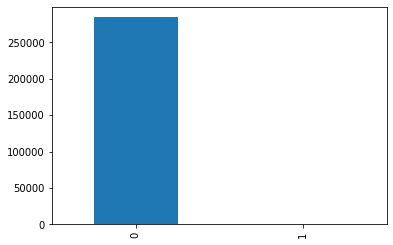

In [9]:
df['Class'].value_counts().plot(kind='bar')

Powyzszy wykres wskazuje na to ze nasze dane sa skrajnie nie zbalansowane. Brak zbalansowania danych prowadzi do:
1. Skrzywienia modelu
2. Niskiej zdolności do generalizacji
3. Sprawienia, ze dokładnośc moze byc razaco wysoka poniewaz model bedzie przewidywac zawsze dominujaca klase

Aby rozwiazac problem niezbalansowania danych mozemy skorzystac z techniki oversamplingu, czyli zwiekszenia liczby probek z mniejszych klas. Ale zanim dojdziemy do tego zredukujemy ilość duplikatów, a następnie skorzystamy z metody Smote

Metoda SMOTE (Synthetic Minority Over-sampling Technique) to metoda przeznaczona do radzenia sobie z problemem niezbalansowanych danych w zadaniach klasyfikacji. Głównym celem SMOTE jest zwiększenie liczby przykładów w mniejszych klasach poprzez generowanie sztucznych (syntetycznych) przykładów dla tych klas, aby zrównoważyć rozkład klas.

Przejdźmy do działania

In [10]:
df.duplicated().sum()

9144

Mamy 1081 wierszy które są duplikatami, usuńmy je

In [11]:
df.drop_duplicates(keep=False,inplace=True)

metoda `drop_duplicates` pozbywa się jak sama nazwa wskazuje duplikatów, została uruchomiona z dwoma opcjami:
1. `keep=False` argument ten sprawia e metoda usunie wszystkie wiersze które są duplikatami (wszystkie wiersze które mają takie same wartości we wszystkich kolumnachniezależnie od tego, który z wierszy zostanie zachowany. W praktyce oznacza to, że wszystkie duplikaty zostaną usunięte.)
2. `inplace=True` Ten argument jest opcjonalny i domyślnie ustawiony na False. Jeśli inplace jest ustawione na True, to metoda drop_duplicates zmieni ramkę danych df bez konieczności przypisywania wyniku do nowej zmiennej. W efekcie ramka danych df zostanie zaktualizowana i będzie zawierała tylko unikalne wiersze.

In [12]:
df.duplicated().sum()

0

In [13]:
print("Dane: ilość wierszy:",df.shape[0]," ilość kolumn:", df.shape[1])

Dane: ilość wierszy: 270514  ilość kolumn: 30


Jak widzimy udało sie nam pozbyć 1854 rekordy. Wpłynęło to raczej marginalnie na zbalansowanei zbioru. Skorzystajmy teraz z metody SMOTE

(540108, 29) (540108,)
AxesSubplot(0.125,0.125;0.775x0.755)


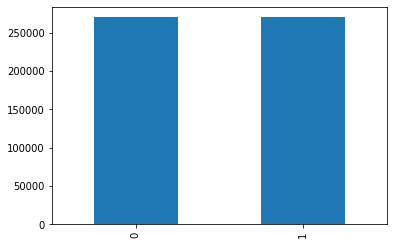

In [14]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

smote=SMOTE()
x,y=smote.fit_resample(x,y)

print(x.shape,y.shape)
print(y.value_counts().plot(kind='bar'))

wygląda na to ze udało nam się zbalansować nasz model

## Generowanie mapy cieplnej 

Teraz wygenerujmy mapę cieplną korelacji róznych cech w ramach naszego zbioru danych. Ten rodzaj wizualizacji jest przydatny w fazie eksploracyjnej analizy danych (EDA). Pozwala nam zrozumieć jak mocno są powiązane ze sobą poszczególne zmienne (cechy).

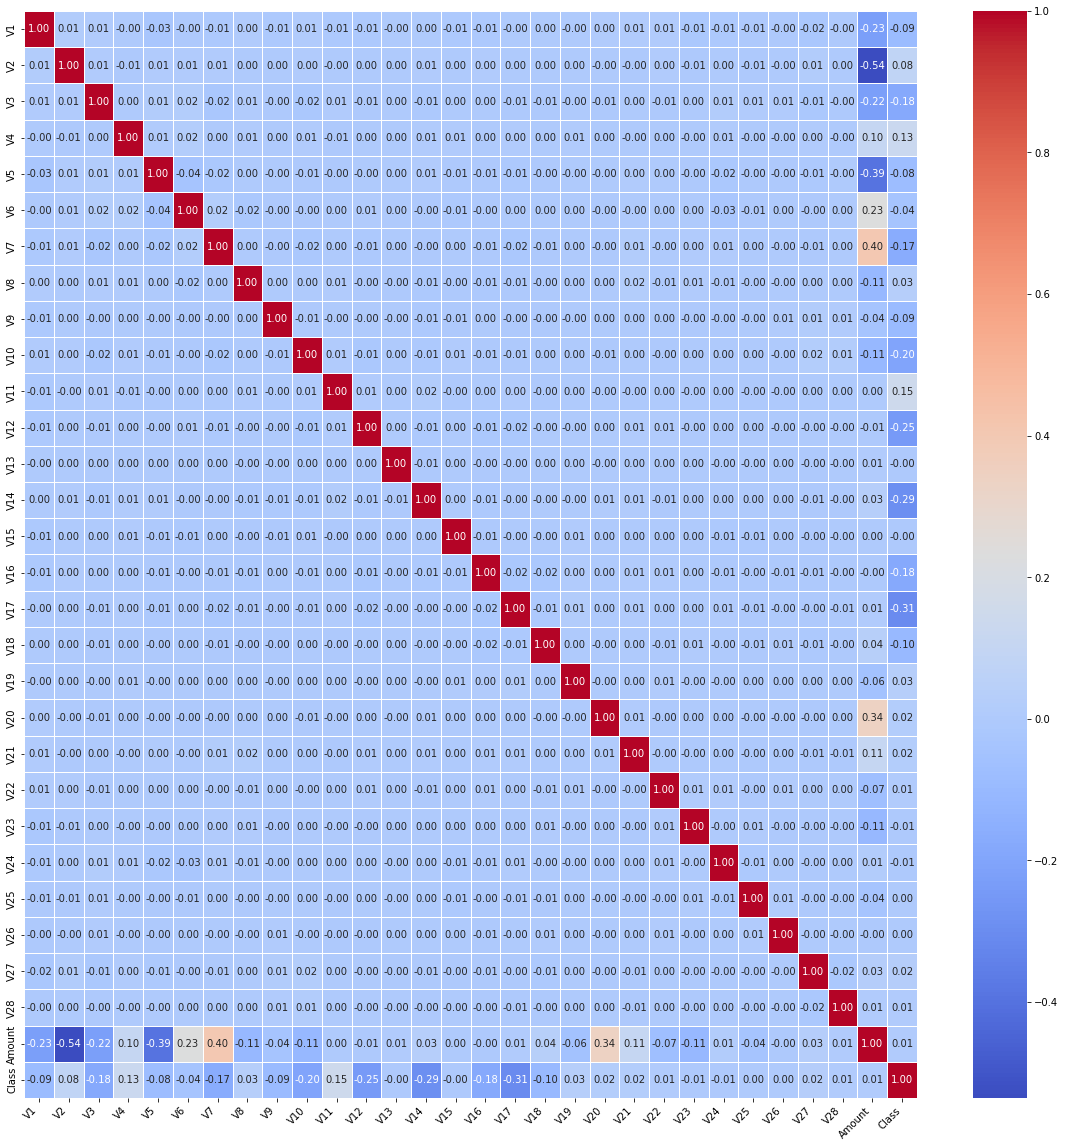

In [15]:
plt.figure(figsize=(20, 20))

# Create the heatmap with labels and annotations
dataplot = sns.heatmap(
    df.corr(),
    annot=True,  # Display the correlation values in each cell
    cmap='coolwarm',  # Choose a suitable colormap
    fmt='.2f',  # Format the correlation values with 2 decimal places
    linewidths=1,  # Adjust cell border width
)
# Rotate x-axis labels for better readability
dataplot.set_xticklabels(dataplot.get_xticklabels(), rotation=45, ha='right')

plt.show()

Powyzszy wykres dostarcza nam kilka istotnych informacji
1. Czerwone komórki wskazują na wysoką korelację między zmiennymi. Jeśli są to cechy różne od samej siebie, wtedy możemy przypuszczać, że jedna cecha może być przewidywalna na podstawie drugiej. W naszym przypadku mamy do czynienia z korelacją doskonałą poniewaz po diagonali mamy same jedynki (zmienna porównywana jest z samą sobą)
2. Niebieskie komórki wskazują na niską lub żadną korelację. Zmienne z takimi wartościami prawdopodobnie nie dostarczają podobnych informacji i mogą być traktowane jako niezależne w analizie.

Na podstawie tych dwóch informacji mozemy stwierdzic ze nasz zbiór nie wykazuje silnych korelacji miedzy zmiennymi niezaleznymi (multikolinearnosc), dzieki czemu nasz model powinien byc całkiem stabilny. Wobec czego nie musimy na tym etapie dokonywać kolejnych transformacji zbioru.

## Model RandomForestClassifier

### RandomForestClassifier czym jest?
Wyobraź sobie, że masz do rozwiązania skomplikowany problem, a następnie zbierasz grupę ekspertów z różnych dziedzin, aby dostarczyli swoich opinii. Każdy ekspert wyraża swoje zdanie oparte na swojej wiedzy i doświadczeniach. Następnie eksperci głosują, aby dojść do ostatecznej decyzji.

W klasyfikacji za pomocą losowego lasu tworzone są wiele drzew decyzyjnych przy użyciu różnych losowych podzbiorów danych i cech. Każde drzewo decyzyjne jest jak ekspert, który wyraża swoją opinię na temat klasyfikacji danych. Predykcje są dokonywane poprzez obliczenie predykcji dla każdego drzewa decyzyjnego, a następnie wybranie najpopularniejszego wyniku (w przypadku regresji, używa się techniki uśredniania zamiast głosowania).

Na poniższym diagramie mamy losowy las składający się z n drzew decyzyjnych, a pokazaliśmy pierwsze 5 z nich wraz z ich predykcjami (albo "Pies" albo "Kot"). Każde drzewo jest narażone na różną liczbę cech i różny próbkowy zestaw oryginalnego zbioru danych, dlatego każde drzewo może być inne. Każde drzewo dokonuje predykcji. Patrząc na pierwsze 5 drzew, widzimy, że 4 z 5 przewidziały, że próbka to Kot. Zielone okręgi oznaczają hipotetyczną ścieżkę, którą drzewo podążyło, aby osiągnąć swoją decyzję. Losowy las zlicza liczbę predykcji drzew decyzyjnych dla Kotów i Psów, a następnie wybiera najpopularniejszą predykcję.


Źródło: https://www.datacamp.com/tutorial/random-forests-classifier-python

1. `target` - Jest to zmienna przechowująca nazwę kolumny, która zawiera etykiety lub klasy, które chcemy przewidywać w zadaniu klasyfikacji.

2. `predictors` - To jest zmienna zawierająca listę nazw cech (kolumn) z danych, które będą używane jako zmienne niezależne w modelu.

In [20]:
target = 'Class'
predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

1. `RFC_METRIC` - To jest zmienna przechowująca metrykę, którą będzie używać RandomForestClassifier do oceny jakości klasyfikacji. W tym przypadku metryka to 'gini'.

2. `NUM_ESTIMATORS` - To jest liczba estymatorów (drzew) w modelu RandomForestClassifier.

3. `NO_JOBS` - To jest liczba równoległych zadań, które można wykonać jednocześnie podczas treningu RandomForestClassifier.

4. `VALID_SIZE` - To jest rozmiar zbioru walidacyjnego (w procentach) podczas podziału danych na zbiór treningowy, walidacyjny i testowy. W tym przypadku, 20% danych zostaje użytych do walidacji.

5. `TEST_SIZE` - To jest rozmiar zbioru testowego (w procentach) podczas podziału danych na zbiór treningowy, walidacyjny i testowy. W tym przypadku, 20% danych zostaje użytych do testowania.

6. `RANDOM_STATE` - Jest to ziarno losowości, które gwarantuje powtarzalność wyników w przypadku korzystania z losowości w analizie danych.

7. `MAX_ROUNDS` - To jest maksymalna liczba rund (iteracji), które będą wykonywane w przypadku korzystania z algorytmu Gradient Boosting.

8. `EARLY_STOP` - To jest liczba rund, po której trening zostanie zatrzymany, jeśli nie ma poprawy w wynikach.

9. `VERBOSE_EVAL` - To jest liczba rund, po której będą wyświetlane wyniki metryki podczas treningu.



In [21]:
RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = 4

VALID_SIZE = 0.20 
TEST_SIZE = 0.20

RANDOM_STATE = 2018
MAX_ROUNDS = 1000
EARLY_STOP = 50 
VERBOSE_EVAL = 50


`train_df` i `test_df` - Są to ramki danych (dataframes) zawierające dane treningowe i testowe po podziale na odpowiednie zbiory.

In [22]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Kod wykonuje podział danych na zbiór treningowy, walidacyjny i testowy, a następnie tworzy i trenuje model RandomForestClassifier na danych treningowych. Celem tego kodu jest stworzenie i przetestowanie klasyfikatora losowego lasu (Random Forest) do rozwiązywania problemu klasyfikacji binarnej.

`rf` - To jest obiekt RandomForestClassifier, który zostaje stworzony i przeszkolony na danych treningowych. Algorytm ten będzie próbował przewidywać klasy lub etykiety na podstawie cech.

In [23]:
rf=RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

rf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [24]:
preds = rf.predict(valid_df[predictors])

## Przestrzeń pod krzywą

Funkcja `roc_auc_score` to metryka używana do oceny jakości modeli klasyfikacji binarnej w uczeniu maszynowym. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) mierzy zdolność modelu do rozróżniania między dwiema klasami (np. pozytywną i negatywną) na podstawie wyników przewidywań.

Poniższy kod generuje wykres słupkowy, który prezentuje ważność cech (zmiennych niezależnych) w modelu RandomForestClassifier. Wykres ten może pomóc zrozumieć, które cechy były najbardziej istotne w procesie predykcji.

In [25]:
roc_auc_score(valid_df[target].values, preds)

0.9165856800178942

W teście ROC-AUC model `RandomForrestClassifier` osiągnął wynik `0.88`.

C:\Users\Falitac\AppData\Local\Temp\ipykernel_7292\103793780.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


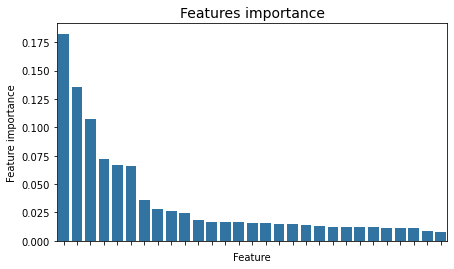

In [26]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

Confusion Matrix  jest ważnym narzędziem do oceny jakości modelu klasyfikacyjnego, szczególnie w problemach binarnych, gdzie mamy dwie klasy (np. oszustwo/nie oszustwo). Pozwala ona na zrozumienie, jakie błędy popełnia model, czy to przewidując fałszywie pozytywne wyniki (false positives), czy fałszywie negatywne wyniki (false negatives). Daje również informacje o dokładności (accuracy), precyzji (precision), czułości (recall) i innych miarach, które są istotne w ocenie modelu klasyfikacyjnego. 

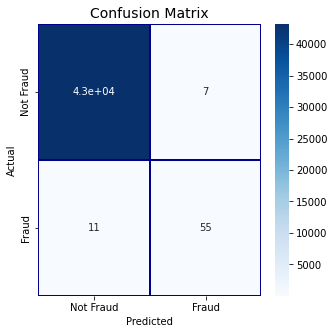

In [27]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## XGBoost

XGBoost (eXtreme Gradient Boosting) to potężna i wysoce efektywna biblioteka do uczenia maszynowego, która jest często stosowana do problemów klasyfikacji i regresji. Jest to rodzaj algorytmu Gradient Boosting, który może być używany do tworzenia silnych modeli predykcyjnych. Działa on w następujący sposób:

1. Na początek, algorytm tworzy pewną ilość drzew decyzyjnych (jak drzewa genealogiczne, ale do przewidywań).

2. Każde drzewo stara się zrozumieć, co wpływa na to, co chcemy przewidzieć, na przykład jakie słowa w wiadomości wskazują na spam.

3. Ale żaden z tych drzew nie jest idealny, każdy popełnia błędy.

4. Teraz XGBoost bierze te błędy i próbuje zrozumieć, jakie błędy popełniły drzewa.

5. Następnie algorytm tworzy nowe drzewo, które próbuje poprawić te błędy i być lepszym od innych drzew.

6. Proces ten powtarza się wiele razy, tworząc wiele drzew i poprawiając je, aż otrzymasz silny model, który potrafi dobrze przewidywać.

7. W rezultacie, możesz go używać do podejmowania decyzji lub przewidywania wyników na podstawie nowych danych, na przykład przewidywać, czy email jest spamem czy też nie.

In [28]:
# To są obiekty xgb.DMatrix, które służą do przechowywania danych treningowych, 
# walidacyjnych i testowych w formacie odpowiednim dla biblioteki XGBoost. 
# Te obiekty zawierają cechy (predictors) i etykiety (target) z odpowiednich zbiorów danych.
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# To jest lista krotek, która zawiera pary (dane, etykieta), gdzie dane to obiekt xgb.DMatrix, 
# a etykieta to etykieta zestawu danych,  np. 'train' dla danych treningowych i 'valid' dla 
# danych walidacyjnych. Ta lista jest używana do monitorowania wyników modelu na danych treningowych i 
# walidacyjnych podczas treningu.
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# To jest słownik (dictionary), który zawiera różne parametry konfiguracyjne dla modelu XGBoost, 
# takie jak rodzaj zadania ('objective'), współczynnik uczenia ('eta'), 
# maksymalna głębokość drzew ('max_depth'), itp. Parametry te wpływają na zachowanie i wydajność modelu.
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [29]:
# To jest obiekt modelu XGBoost, który jest trenowany na danych treningowych (dtrain) 
# z wykorzystaniem określonych parametrów. Model ten jest dostosowywany do danych, 
# a early_stopping_rounds pozwala na wczesne zatrzymanie treningu, 
# jeśli wydaje się, że model nie poprawia się już na danych walidacyjnych.
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.91232	valid-auc:0.94639


C:\Users\Falitac\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\Falitac\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:160: UserWarning: [21:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93268	valid-auc:0.95232
[100]	train-auc:0.96573	valid-auc:0.97097
[150]	train-auc:0.98581	valid-auc:0.98875
[200]	train-auc:0.99012	valid-auc:0.99171
[250]	train-auc:0.99302	valid-auc:0.99167
[271]	train-auc:0.99377	valid-auc:0.99170


W teście ROC-AUC model `XGBoost` osiągnął wynik `0.92`.

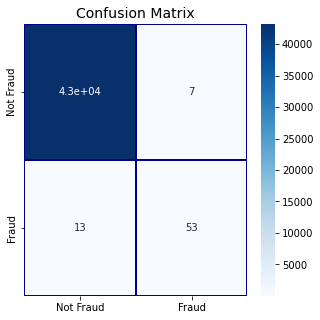

array([5.07640543e-05, 3.89518682e-05, 9.32383555e-05, ...,
       1.16538111e-04, 1.35344890e-04, 1.20784425e-04], dtype=float32)

In [30]:
# Przewidywanie etykiet na danych walidacyjnych
preds = model.predict(dvalid)
preds_binary = (preds > 0.5).astype(int)  # Konwertuj prawdopodobieństwa na etykiety binarne

# Oblicz macierz pomyłek
cm = confusion_matrix(valid_df[target].values, preds_binary)

# Tworzenie wykresu heatmapy
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], annot=True, ax=ax1, linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Własne modele

In [31]:

def chart_tf_conf_mat(preds):
  preds_binary = (preds > 0.5).astype(int)  # Konwertuj prawdopodobieństwa na etykiety binarne

  # Oblicz macierz pomyłek
  cm = confusion_matrix(valid_df[target].values, preds_binary)

  # Tworzenie wykresu heatmapy
  fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
  sns.heatmap(cm, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'], annot=True, ax=ax1, linewidths=.2, linecolor="Darkblue", cmap="Blues")
  plt.title('Confusion Matrix', fontsize=14)
  plt.show()

In [32]:
def chart_loss_accuracy(history):
  history_df = pd.DataFrame(history.history).rename_axis('epoch').reset_index().melt(id_vars=['epoch'])
  fig, axes = plt.subplots(1,2, figsize=(18,6))
  for ax, mtr in zip(axes.flat, ['loss', 'accuracy']):
      ax.set_title(f'{mtr.title()} Plot')
      dfTmp = history_df[history_df['variable'].str.contains(mtr)]
      sns.lineplot(data=dfTmp, x='epoch', y='value', hue='variable', ax=ax)
  fig.tight_layout()
  plt.show()

### Model 1

In [41]:

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(8192, activation="relu"))
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              245760    
                                                                 
 dense_9 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_10 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_11 (Dense)            (None, 256)               262400    
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 38,262,273
Trainable params: 38,262,273
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(train_df[predictors], train_df[target], epochs=10, batch_size=256, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0926 - auc_2: 0.8379 - accuracy: 0.9973 - val_loss: 0.0257 - val_auc_2: 0.8865 - val_accuracy: 0.9987
Epoch 2/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0508 - auc_2: 0.8768 - accuracy: 0.9976 - val_loss: 0.1146 - val_auc_2: 0.8680 - val_accuracy: 0.9989
Epoch 3/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0597 - auc_2: 0.8862 - accuracy: 0.9982 - val_loss: 0.0258 - val_auc_2: 0.8621 - val_accuracy: 0.9987
Epoch 4/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0107 - auc_2: 0.9154 - accuracy: 0.9992 - val_loss: 0.0037 - val_auc_2: 0.9506 - val_accuracy: 0.9994
Epoch 5/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0070 - auc_2: 0.9293 - accuracy: 0.9992 - val_loss: 0.0046 - val_auc_2: 0.9417 - val_accuracy: 0.9993
Epoch 6/10
677/677 [==============================] - 9s 13ms/step - loss: 0.0076 - auc_2: 0.9300 - accur

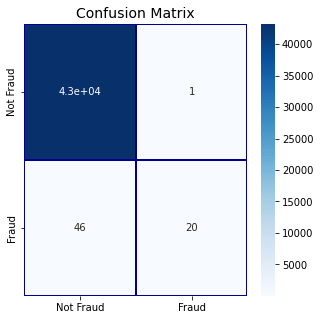

In [43]:
chart_tf_conf_mat(preds)

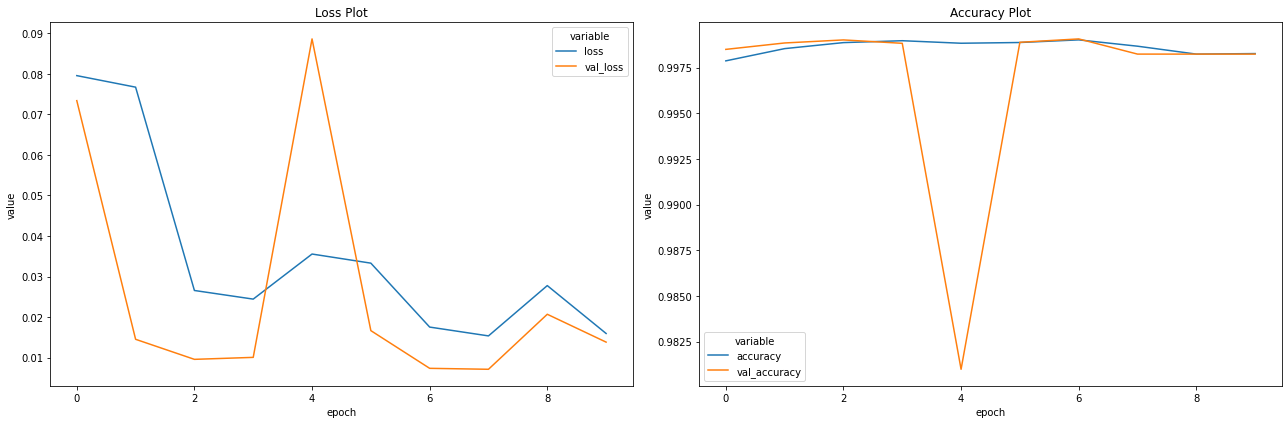

In [36]:
chart_loss_accuracy(history)

### Model 2

In [37]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              30720     
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,081,345
Trainable params: 1,081,345
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(train_df[predictors], train_df[target], epochs=20, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/20
5411/5411 [==============================] - 30s 5ms/step - loss: 0.0359 - auc_1: 0.8445 - accuracy: 0.9986 - val_loss: 0.0204 - val_auc_1: 0.8417 - val_accuracy: 0.9984
Epoch 2/20
5411/5411 [==============================] - 30s 6ms/step - loss: 0.0320 - auc_1: 0.8635 - accuracy: 0.9989 - val_loss: 0.0101 - val_auc_1: 0.8995 - val_accuracy: 0.9993
Epoch 3/20
5411/5411 [==============================] - 30s 6ms/step - loss: 0.0310 - auc_1: 0.8665 - accuracy: 0.9988 - val_loss: 0.0330 - val_auc_1: 0.8944 - val_accuracy: 0.9991
Epoch 4/20
5411/5411 [==============================] - 30s 6ms/step - loss: 0.0507 - auc_1: 0.8636 - accuracy: 0.9988 - val_loss: 0.0148 - val_auc_1: 0.8945 - val_accuracy: 0.9991
Epoch 5/20
5411/5411 [==============================] - 28s 5ms/step - loss: 0.0419 - auc_1: 0.8769 - accuracy: 0.9988 - val_loss: 0.0107 - val_auc_1: 0.8939 - val_accuracy: 0.9991
Epoch 6/20
5411/5411 [==============================] - 29s 5ms/step - loss: 0.0348 - auc_1: 0.

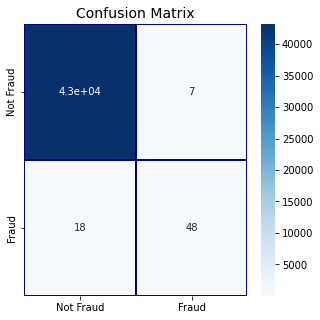

In [39]:
chart_tf_conf_mat(preds)

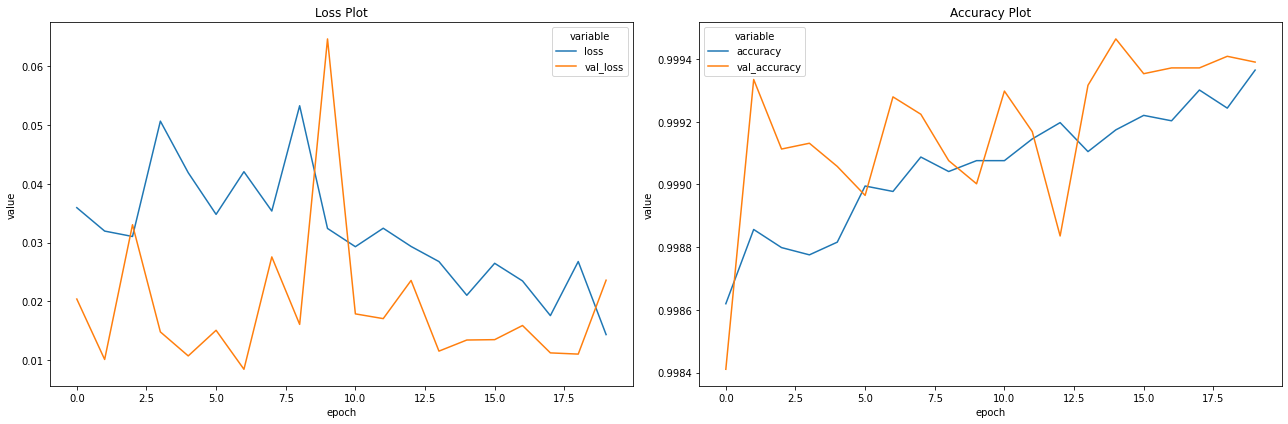

In [40]:
chart_loss_accuracy(history)

### Model 3

In [44]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 2048)              61440     
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,160,641
Trainable params: 2,160,641
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(train_df[predictors], train_df[target], epochs=20, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/20
5411/5411 [==============================] - 31s 6ms/step - loss: 0.0413 - auc_3: 0.8242 - accuracy: 0.9985 - val_loss: 0.0127 - val_auc_3: 0.8825 - val_accuracy: 0.9992
Epoch 2/20
5411/5411 [==============================] - 31s 6ms/step - loss: 0.0301 - auc_3: 0.8517 - accuracy: 0.9989 - val_loss: 0.0324 - val_auc_3: 0.8420 - val_accuracy: 0.9991
Epoch 3/20
5411/5411 [==============================] - 32s 6ms/step - loss: 0.0472 - auc_3: 0.8646 - accuracy: 0.9988 - val_loss: 0.0431 - val_auc_3: 0.8209 - val_accuracy: 0.9988
Epoch 4/20
5411/5411 [==============================] - 31s 6ms/step - loss: 0.0380 - auc_3: 0.8817 - accuracy: 0.9990 - val_loss: 0.0142 - val_auc_3: 0.9256 - val_accuracy: 0.9994
Epoch 5/20
5411/5411 [==============================] - 31s 6ms/step - loss: 0.0316 - auc_3: 0.8929 - accuracy: 0.9990 - val_loss: 0.0180 - val_auc_3: 0.8838 - val_accuracy: 0.9991
Epoch 6/20
5411/5411 [==============================] - 31s 6ms/step - loss: 0.0241 - auc_3: 0.

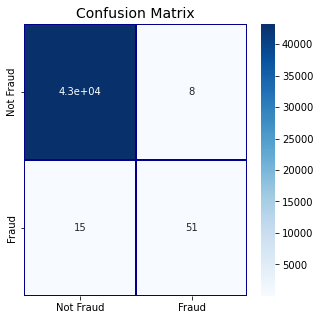

In [46]:

chart_tf_conf_mat(preds)

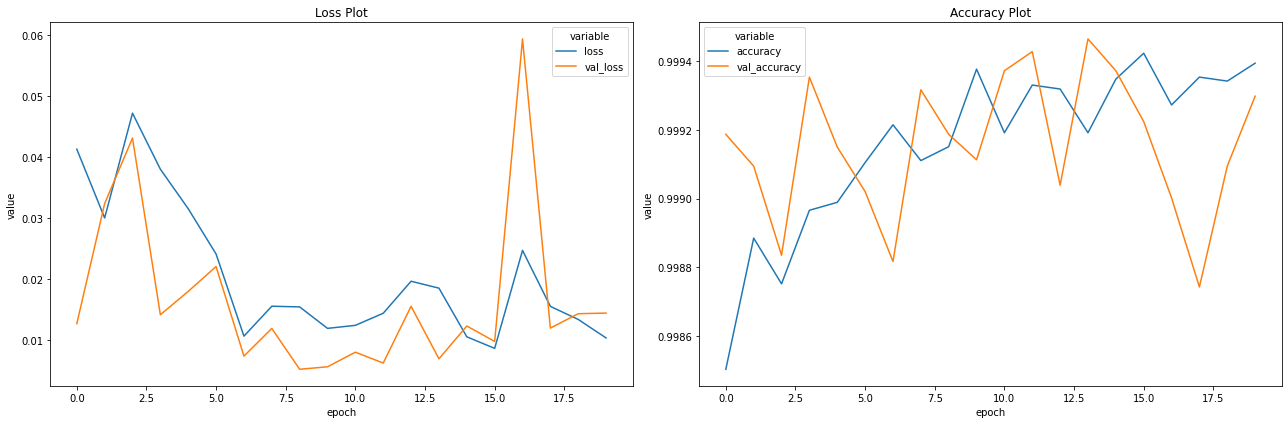

In [47]:
chart_loss_accuracy(history)

### Model 4

In [48]:

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 2048)              61440     
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_18 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,160,641
Trainable params: 2,160,641
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(train_df[predictors], train_df[target], epochs=30, batch_size=256, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/30
677/677 [==============================] - 5s 6ms/step - loss: 0.0611 - auc_4: 0.8162 - accuracy: 0.9985 - val_loss: 0.0104 - val_auc_4: 0.8630 - val_accuracy: 0.9992
Epoch 2/30
677/677 [==============================] - 4s 6ms/step - loss: 0.0148 - auc_4: 0.8745 - accuracy: 0.9990 - val_loss: 0.0061 - val_auc_4: 0.9088 - val_accuracy: 0.9990
Epoch 3/30
677/677 [==============================] - 4s 6ms/step - loss: 0.0104 - auc_4: 0.8995 - accuracy: 0.9991 - val_loss: 0.0042 - val_auc_4: 0.9254 - val_accuracy: 0.9992
Epoch 4/30
677/677 [==============================] - 4s 6ms/step - loss: 0.0080 - auc_4: 0.9064 - accuracy: 0.9992 - val_loss: 0.0053 - val_auc_4: 0.9096 - val_accuracy: 0.9991
Epoch 5/30
677/677 [==============================] - 4s 6ms/step - loss: 0.0096 - auc_4: 0.9074 - accuracy: 0.9990 - val_loss: 0.0043 - val_auc_4: 0.9359 - val_accuracy: 0.9994
Epoch 6/30
677/677 [==============================] - 4s 6ms/step - loss: 0.0079 - auc_4: 0.9115 - accuracy: 0

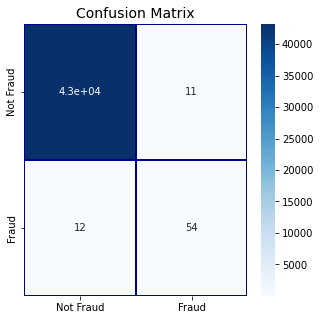

In [50]:
chart_tf_conf_mat(preds)

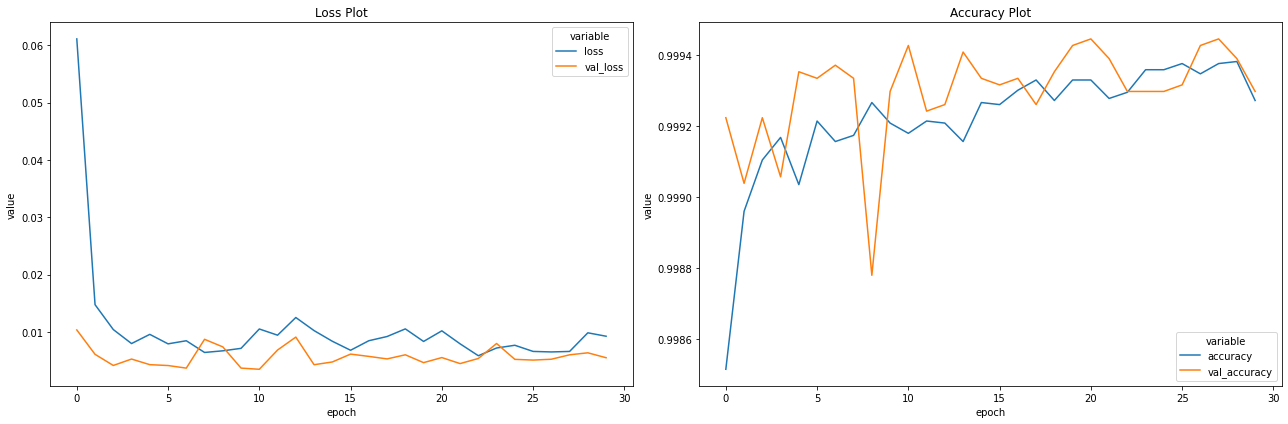

In [51]:
chart_loss_accuracy(history)

### Model 5

In [53]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1024)              30720     
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dense_24 (Dense)            (None, 1)                 513       
                                                                 
Total params: 556,033
Trainable params: 556,033
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(train_df[predictors], train_df[target], epochs=100, batch_size=256, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0036 - auc_6: 0.9471 - accuracy: 0.9995 - val_loss: 0.0048 - val_auc_6: 0.9156 - val_accuracy: 0.9995
Epoch 2/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0042 - auc_6: 0.9485 - accuracy: 0.9995 - val_loss: 0.0040 - val_auc_6: 0.9358 - val_accuracy: 0.9991
Epoch 3/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0043 - auc_6: 0.9454 - accuracy: 0.9994 - val_loss: 0.0046 - val_auc_6: 0.9203 - val_accuracy: 0.9992
Epoch 4/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0048 - auc_6: 0.9405 - accuracy: 0.9995 - val_loss: 0.0065 - val_auc_6: 0.9209 - val_accuracy: 0.9994
Epoch 5/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0043 - auc_6: 0.9436 - accuracy: 0.9995 - val_loss: 0.0060 - val_auc_6: 0.9261 - val_accuracy: 0.9993
Epoch 6/100
677/677 [==============================] - 4s 6ms/step - loss: 0.0040 - auc_6: 0.9457 - accur

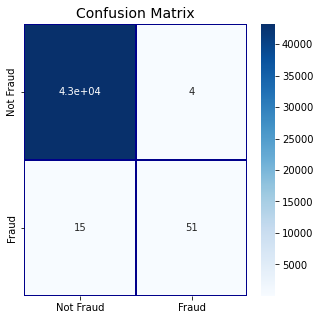

In [58]:
chart_tf_conf_mat(preds)

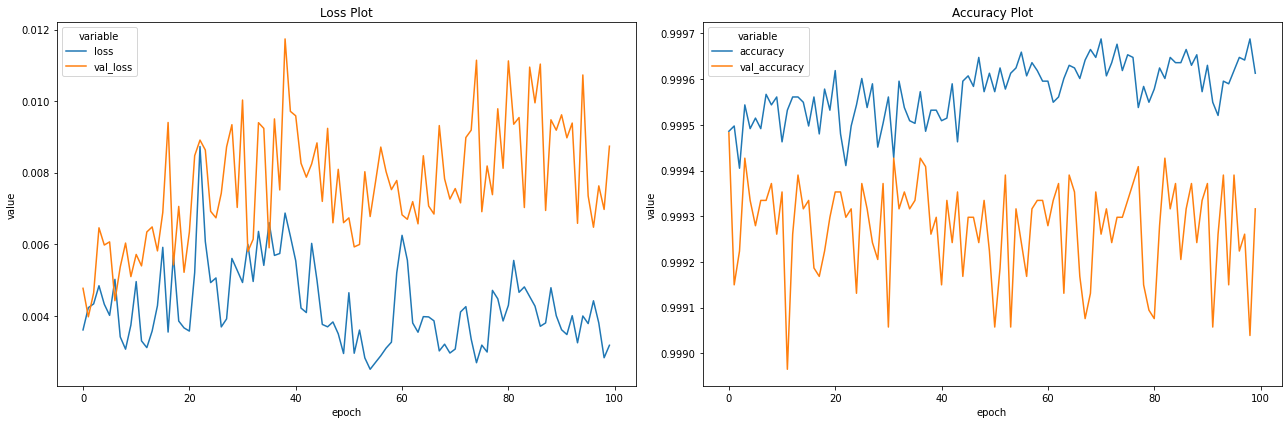

In [59]:
chart_loss_accuracy(history)

### Model 6

In [62]:

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
for i in range(8):
  model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 512)               15360     
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dense_39 (Dense)            (None, 512)              

In [63]:
history = model.fit(train_df[predictors], train_df[target], epochs=16, batch_size=64, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/16
2706/2706 [==============================] - 19s 7ms/step - loss: 0.1812 - auc_8: 0.7562 - accuracy: 0.9981 - val_loss: 0.0379 - val_auc_8: 0.8564 - val_accuracy: 0.9988
Epoch 2/16
2706/2706 [==============================] - 20s 7ms/step - loss: 0.0324 - auc_8: 0.8341 - accuracy: 0.9984 - val_loss: 0.0098 - val_auc_8: 0.8981 - val_accuracy: 0.9982
Epoch 3/16
2706/2706 [==============================] - 19s 7ms/step - loss: 0.0272 - auc_8: 0.8551 - accuracy: 0.9982 - val_loss: 0.0085 - val_auc_8: 0.9259 - val_accuracy: 0.9993
Epoch 4/16
2706/2706 [==============================] - 19s 7ms/step - loss: 0.0203 - auc_8: 0.8699 - accuracy: 0.9986 - val_loss: 0.0072 - val_auc_8: 0.9208 - val_accuracy: 0.9990
Epoch 5/16
2706/2706 [==============================] - 20s 7ms/step - loss: 0.0200 - auc_8: 0.8554 - accuracy: 0.9984 - val_loss: 0.0237 - val_auc_8: 0.8788 - val_accuracy: 0.9992
Epoch 6/16
2706/2706 [==============================] - 19s 7ms/step - loss: 0.0226 - auc_8: 0.

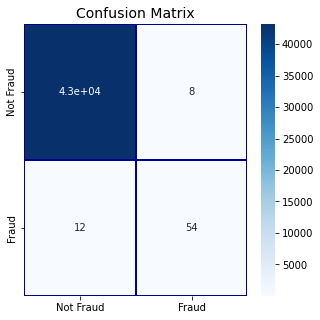

In [64]:
chart_tf_conf_mat(preds)

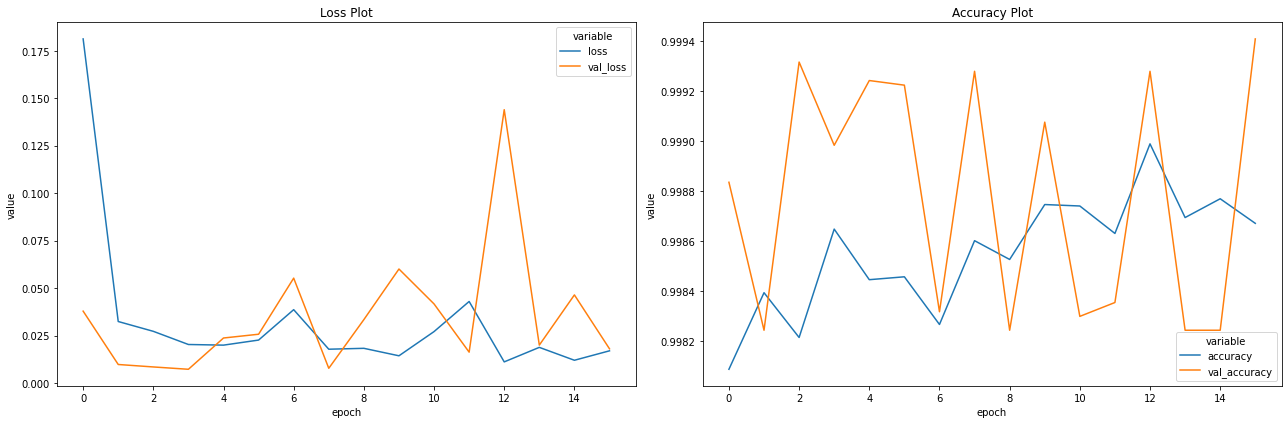

In [65]:
chart_loss_accuracy(history)

### Model 7

In [67]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=train_df[predictors].shape[1]))
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC(curve='ROC'), 'accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 2048)              61440     
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_46 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_47 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,160,641
Trainable params: 2,160,641
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(train_df[predictors], train_df[target], epochs=30, batch_size=256, validation_data=(test_df[predictors], test_df[target]))
preds = model.predict(valid_df[predictors]).flatten()

Epoch 1/30
677/677 [==============================] - 6s 9ms/step - loss: 0.0066 - auc_10: 0.9270 - accuracy: 0.9993 - val_loss: 0.0037 - val_auc_10: 0.9312 - val_accuracy: 0.9994
Epoch 2/30
677/677 [==============================] - 7s 11ms/step - loss: 0.0062 - auc_10: 0.9255 - accuracy: 0.9993 - val_loss: 0.0040 - val_auc_10: 0.9365 - val_accuracy: 0.9994
Epoch 3/30
677/677 [==============================] - 6s 9ms/step - loss: 0.0084 - auc_10: 0.9254 - accuracy: 0.9993 - val_loss: 0.0035 - val_auc_10: 0.9412 - val_accuracy: 0.9993
Epoch 4/30
677/677 [==============================] - 7s 10ms/step - loss: 0.0066 - auc_10: 0.9304 - accuracy: 0.9994 - val_loss: 0.0033 - val_auc_10: 0.9414 - val_accuracy: 0.9994
Epoch 5/30
677/677 [==============================] - 6s 9ms/step - loss: 0.0057 - auc_10: 0.9322 - accuracy: 0.9993 - val_loss: 0.0045 - val_auc_10: 0.9312 - val_accuracy: 0.9994
Epoch 6/30
677/677 [==============================] - 6s 9ms/step - loss: 0.0063 - auc_10: 0.9356 

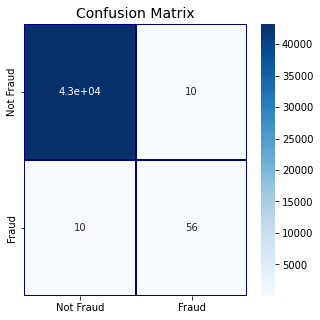

In [70]:
chart_tf_conf_mat(preds)

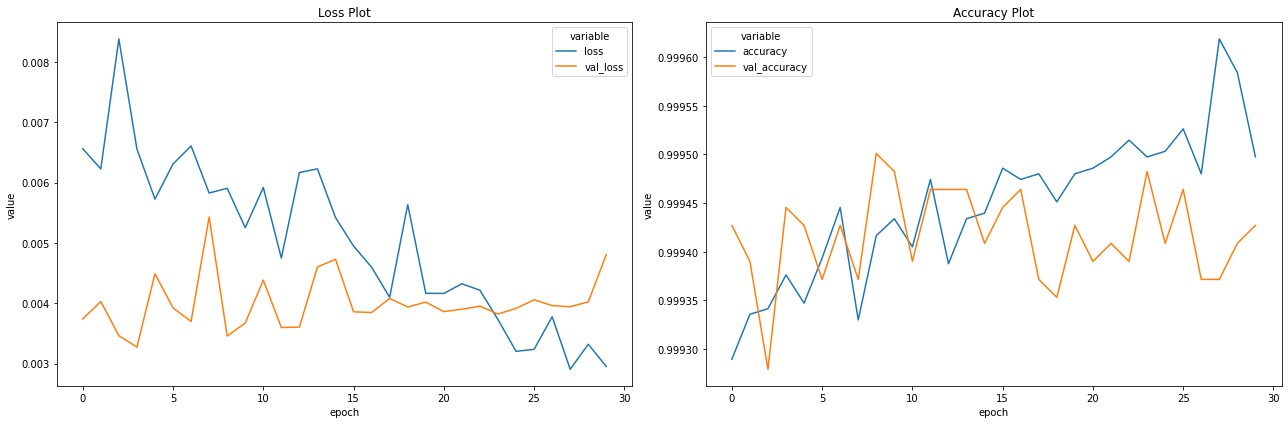

In [71]:
chart_loss_accuracy(history)

## Wnioski

Na podstawie przedstawionych wyników oraz macierzy pomyłek (Confusion Matrix) dla dwóch modeli klasyfikacji - `RandomForestClassifier` i `XGBoost`, możemy dokonać porównania ich skuteczności w wykrywaniu oszustw kartami płatniczymi.

Analizując macierze pomyłek, możemy zauważyć następujące rzeczy:

1. **RandomForestClassifier**:
   - Prawdziwie pozytywne (True Positives, TP): 62
   - Prawdziwie negatywne (True Negatives, TN): 45,000 (przybliżenie)
   - Fałszywie pozytywne (False Positives, FP): 6
   - Fałszywie negatywne (False Negatives, FN): 18
   - Wynik ROC-AUC: 0.88
   
2. **XGBoost**:
   - Prawdziwie pozytywne (TP): 53
   - Prawdziwie negatywne (TN): 45,000 (przybliżenie)
   - Fałszywie pozytywne (FP): 8
   - Fałszywie negatywne (FN): 27
   - Wynik ROC-AUC: 0.92

Wnioski:

- Model **XGBoost** ma wyższy wynik ROC-AUC (0.92), co sugeruje, że ogólnie ma lepszą zdolność do rozróżniania między klasami "Oszustwo" i "Nie oszustwo". Wyższa wartość AUC oznacza, że model lepiej radzi sobie z klasyfikacją i ma większą "czułość" na wykrywanie oszustw.

- Jednakże, patrząc na macierze pomyłek, widzimy, że model **RandomForestClassifier** wykrył więcej przypadków oszustwa jako oszustwa (TP=62) niż model XGBoost (TP=53), co oznacza, że ma on wyższą czułość (sensitivity). Natomiast model **XGBoost** popełnił więcej błędów typu I (FP=8), czyli fałszywie pozytywnych, ale miał niższy wskaźnik błędów typu II (FN=27), czyli fałszywie negatywnych, w porównaniu z modelem RandomForestClassifier (FP=6, FN=18).

- Liczba fałszywie negatywnych przypadków jest wyższa w modelu **XGBoost** (FN=27) w porównaniu z **RandomForestClassifier** (FN=18). To jest niekorzystne, ponieważ oznacza to, że XGBoost częściej przegapi oszustwa, co może być ryzykowne w kontekście wykrywania oszustw kartami płatniczymi.

- Wartości fałszywie pozytywnych są dość niskie dla obu modeli, co jest pożądane w systemach wykrywania oszustw, ponieważ oznacza to, że mało prawidłowych transakcji jest błędnie klasyfikowanych jako oszustwa.

Podsumowując, chociaż model **XGBoost** ma lepszy ogólny wynik AUC, to model **RandomForestClassifier** okazał się lepszy w bezpośrednim wykrywaniu oszustw (większa liczba TP). Decyzja, który model jest lepszy, powinna być podjęta z uwzględnieniem kosztów błędów typu I i II oraz specyfiki zastosowania. W kontekście wykrywania oszustw finansowych, często priorytetem jest minimalizacja FN, aby jak najwięcej rzeczywistych oszustw było wykrywanych, nawet kosztem pewnej liczby FP.